# Transfer Learning with Pytorch

In this excercise, you will implement a 2-class classification neural network, using transfer learning from a pre-trained resnet18 network. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve (but not identical). The pre-trained network could have been trained on a different dataset and sometimes also on a different task. The important thing is that it would be a related task and a realted dataset. This way, we can leverage previous learneinng to solve the new problem (instead of training the model from scratch). The ResNet18 model was pre-trained on the [ImageNet](http://image-net.org/index) dataset (a large dataset consisting of 1.4M images and 1000 classes). 

Transfer learning can be used in two ways:
1. Feature extractor: Here we remove top layers, freeze the weights of all remaining layers, add a new fully connected layers on top of the pretrained model. Then. we train only these new layers to solve the new task.
2. Fine tuning: Here we unfreezing the entire model (or part of it), add a new fully connected layers on top of the pre-trained model (as before) and re-train the entire model on the new data with a very low learning rate. We can use either end-to-end re-training, or re-train only part of the network.

### CIFAR-10 Dataset:

In this assignment, you will need to perform transfer learning using the ResNet18 network in order to classify and discern between images of cats and dogs in a different dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 



# Part 1- Feature Extractor

In this part of the exercise, you need to classify images of 'Cat' and 'Dog' by using transfer learning with the feature extractor approach and a pre-trained ResNet18 network.

The pre-trained model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers. You will need to extract the image representation that should be fed into a classifier. For the classifier, please use a single fully-connected layer. 


In order to make things efficient, start by using the ResNet18 network in order to extract image represetnations for the images in CIFAR-10 dataset. Please make sure to this only once (please do not extract the image representations each time it is needed in the training phase)! You can store the resulting image representations as feature vectors and train the classifier using these vectors. At test time, you can merge both network in order to achive a single end-to-end classifier.  
Note: This is different from what you saw in the recitation (dl_r4_cnns).

At the test time, you can merge the feature extraction netowork with the new prediction head, in order to recive a "full solution".


**Let's first import all the packages that you will need during this part of assignment:**

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time
import tqdm
from tqdm import tqdm
import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

The ResNet18 network requires images of at least 200x200 pixels. However, the CIFAR-10 dataset consists of small images of 32x32 pixels. Hence, you will need to reshape the images before we use them into the ResNet18 network.
Additionally, you will need to match the normalization used while training the ResNet18: each color channel should be normalized separately. The channel means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

**Use the transforms library from  torchvision and definethese transformations:**

In [2]:
# Specify transforms using torchvision.transforms as transforms library
class NetArgs:
    lr = 1e-3
    num_epochs = 75
    early_stopping_min_improvement = 1e-3
    early_stopping_num_epochs = 10
    batch_size = 150

train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225]),
    ]
)
infer_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225]),
    ]
)


#### Load CIFAR10 dataset and transform dataset from torchvision:

In [3]:
from torch.utils.data import DataLoader, Dataset
import random


class CIFAR10_DataLoader_Len_Limited(Dataset):
    def __init__(self, original_datset, len_limit=None):
        self.len_limit = len_limit
        self.original_datset = original_datset
        self.label_to_indices = {label: np.where(np.array(self.original_datset.targets) == label)[0].tolist()
                                 for label in [0, 1]}
        """random.shuffle(self.label_to_indices[0])
        random.shuffle(self.label_to_indices[1])"""
        self.ind_0 = 0
        self.ind_1 = 0

    def __getitem__(self, ind):
        if(self.ind_0 <= self.ind_1):
            next_ind = self.label_to_indices[0][self.ind_0]
            label = self.original_datset.targets[next_ind]
            self.ind_0 += 1
            if(ind == self.len_limit-1):
                self.ind_0 = 0
                self.ind_1 = 0
            return self.original_datset[next_ind]
        else:
            next_ind = self.label_to_indices[1][self.ind_1]
            label = self.original_datset.targets[next_ind]
            self.ind_1 += 1
            if(ind == self.len_limit-1):
                self.ind_0 = 0
                self.ind_1 = 0
            return self.original_datset[next_ind]

    def __len__(self):
        if self.len_limit:
            return min(len(self.original_datset), self.len_limit)
        return len(self.original_datset)

class SubLoader(torchvision.datasets.CIFAR10):
    def __init__(self, exclude_list, *args, **kwargs):
        super(SubLoader, self).__init__(*args, **kwargs)

        if exclude_list == []:
            return
        labels = np.array(self.targets)
        exclude = np.array(exclude_list).reshape(1, -1)
        mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)
        self.data = self.data[mask]
        self.targets = labels[mask].tolist()
        self.targets = list(map(lambda x: 1 if x == 5 else 0, self.targets))



In [4]:
# Note: In order to separating the data/label you can apply "classes"/"targets" methods on CIFAR10 data sets
args=NetArgs()
labels = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
print(labels)
exclude_labels = labels
del exclude_labels['dog']
del exclude_labels['cat']
exclude_labels = list(exclude_labels.values())
#include_labels = [labels["cat"], labels["dog"]]
tr_dataset = SubLoader(exclude_labels, "cifar",
                        transform=train_transform, train=True, download=True)
tr_dataloader = DataLoader(
    CIFAR10_DataLoader_Len_Limited(tr_dataset, int(800*2)), batch_size=args.batch_size
)
val_dataset = SubLoader(exclude_labels, "cifar",
                        transform=infer_transform, train=False, download=True)
val_dataloader = DataLoader(
    CIFAR10_DataLoader_Len_Limited(val_dataset, int(250*2)), batch_size=int(250*2))



{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Files already downloaded and verified
Files already downloaded and verified


**Note that the CIFAR10 data set includes 10 labels. Please extract from the entire dataset, only the images with 'Cat' or 'Dog' labels.
In order to make the training process faster, you will need to trim the train set to 800 training images of each label (800 dogs and 800 cats). The test set should be trimmed to 250 images of cats and 250 images of dogs.**

**Download the ResNet18 Network from torchvision.models (as seen in the tutorial):**

In [11]:
import matplotlib.pyplot as plt



class MyResNet(nn.Module):

    def __init__(self,classifyer):
        super(MyResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Identity()
        self.features = resnet
        # Freezing resnet params:
        for param in self.features.parameters():
            param.requires_grad = False
        # fc layer with softMax for classifying
        self.classifyer = classifyer

    def extract_features(self, X):
        self.features.eval()
        with torch.no_grad():
            return self.features(X)

    def forward(self, X):
        if(len(X.shape) != 4):
            return self.classifyer(X)
        else:
            X = self.features(X)
            return self.classifyer(X)


def infer(net, criterion, X=None, y=None, dataloader=None):  # can pass to function dataloader or X,y
    net.eval()
    running_loss = 0
    running_auc = 0
    num_of_rows = 0
    with torch.no_grad():
        if(dataloader == None):
            pred = net(X)
            loss = criterion(pred, y).item()
            auc = roc_auc_score(y,pred.numpy()[:,1])
            return loss, auc
        else:
            for X_batch, y_batch in dataloader:
                pred = net(X_batch)
                loss = criterion(pred, y_batch).item()
                auc = roc_auc_score(y_batch,pred.numpy()[:,1])
                running_loss += loss*y_batch.shape[0]
                running_auc += auc*y_batch.shape[0]
                num_of_rows += y_batch.shape[0]
            return running_loss / num_of_rows , running_auc / num_of_rows


def training_loop(
    args,
    net,
    X_train,
    y_train,
    val_dataloader,
    criterion_func=nn.CrossEntropyLoss,
    optimizer_func=optim.SGD,
):
    criterion = criterion_func()
    optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=1e-5)
    tr_loss, val_loss = [None] * args.num_epochs, [None] * args.num_epochs
    tr_auc, val_auc = [None] * args.num_epochs, [None] * args.num_epochs
    test_loss, untrained_test_loss = None, None
    test_auc, untrained_test_auc = None, None
    # Note that I moved the inferences to a function because it was too much code duplication to read.
    # calculate error before training
    
    auc_and_loss  = infer(
        net,  criterion, dataloader=val_dataloader)
    untrained_test_loss = auc_and_loss[0]
    untrained_test_auc = auc_and_loss[1]
    for epoch in range(args.num_epochs):
        net.train()
        running_tr_loss = 0
        running_tr_auc = 0
        data_size = len(X_train)
        if(data_size % args.batch_size == 0):
            no_of_batches = data_size // args.batch_size
        else:
            no_of_batches = (data_size // args.batch_size)+1
        for i in tqdm(range(no_of_batches)):
            start = i*args.batch_size
            end = i*args.batch_size + args.batch_size
            x = X_train[start:end]
            y = y_train[start:end]
            optimizer.zero_grad()
            pred = net(x)
            auc = roc_auc_score(y,pred.detach().numpy()[:,1])
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            running_tr_loss += loss*x.shape[0]
            running_tr_auc += auc*x.shape[0]

        tr_loss[epoch] = running_tr_loss.item() / data_size
        tr_auc[epoch] = running_tr_auc.item() / data_size
        auc_and_loss = infer(net, criterion, dataloader=val_dataloader)
        val_loss[epoch] = auc_and_loss[0]
        val_auc[epoch] = auc_and_loss[1]
        print(
            f"Train loss: {tr_loss[epoch]:.2e}, Val loss: {val_loss[epoch]:.2e}")
        if epoch >= args.early_stopping_num_epochs:
            improvement = (
                val_loss[epoch - args.early_stopping_num_epochs] -
                val_loss[epoch]
            )
            if improvement < args.early_stopping_min_improvement:
                break

    auc_and_loss = infer(net, criterion, dataloader=val_dataloader)
    test_loss = test_loss[0]
    test_auc = test_loss[1]
    print(f"Stopped training after {epoch+1}/{args.num_epochs} epochs.")
    print(
        f"The loss is {untrained_test_loss:.2e} before training and {test_loss:.2e} after training."
    )
    print(
        f"The training and validation losses are "
        f"\n\t{tr_loss}, \n\t{val_loss}, \n\tover the training epochs, respectively."
    )
    return tr_loss, val_loss, test_loss,tr_auc,val_auc, untrained_test_loss,untrained_test_auc


def plot_loss_graph(train_loss_list, validation_loss_list):
    plt.plot(train_loss_list, 'g', label='Training loss')
    plt.plot(validation_loss_list, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    """
    loss_values = loss_list
    epochs = range(1, len(loss_values)+1)
    plt.plot(epochs, loss_values, label=f'{train_or_val} Loss by epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()"""


def plot_auc_graph(auc_train_list,auc_val_list):
    plt.plot(auc_train_list, 'g', label='Training loss')
    plt.plot(auc_val_list, 'b', label='validation loss')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


def plot_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve on test set')
    plt.legend(loc="lower right")
    plt.show()


#### Now, use the pre-trained Resnet18 to extract feautres from the CIFAR10 dataset and feed your classifier with these feature vectors. To do that, you need to cut the head of the pre-trained ResNet18 model, then feed the model with the CIFAR10 data sets (train and test).  The resulting image representations should be "flattened" and used as feature vectors:

In [12]:
classifyer = nn.Sequential(nn.Linear(512,2))
net = MyResNet(classifyer)
X_extracted_features_train = torch.empty([0, 512])
y_extracted_features_train = torch.empty([0]).long()
X_extracted_features_test = torch.empty([0, 512])
y_extracted_features_test = torch.empty([0]).long()

for X, y in tr_dataloader:
    print(1)
    extracted_batch_features = net.extract_features(X)
    X_extracted_features_train = torch.cat(
        [X_extracted_features_train, extracted_batch_features], dim=0)
    y_extracted_features_train = torch.cat(
        [y_extracted_features_train, y], dim=0)

for X, y in val_dataloader:
    extracted_batch_features = net.extract_features(X)
    X_extracted_features_test = torch.cat(
        [X_extracted_features_test, extracted_batch_features], dim=0)
    y_extracted_features_test = torch.cat(
        [y_extracted_features_test, y], dim=0)
print(X_extracted_features_train.shape)
print(X_extracted_features_test.shape)


1
1
1
1
1
1
1
1
1
1
1
torch.Size([1600, 512])
torch.Size([500, 512])


# Logistic Regression with scikit-learn library:

#### Here, you need to use a logistic regession model from scikit-learn and train it with the data you prepared above. You need to calculate and report the accuracy and AUC for the train and test sets and explain your results.

In [7]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000)
clf = logisticRegr.fit(X_extracted_features_train, y_extracted_features_train)
pred=clf.predict(X_extracted_features_test)
accuracy=clf.score(X_extracted_features_test,y_extracted_features_test)
auc=roc_auc_score(pred,y_extracted_features_test)

print('accuracy:',accuracy)
print('auc',auc)





accuracy: 0.816
auc 0.816080916714679


# Logistic Regression with pytorch:

#### Next, you need to use a logistic regession using pythourch as follows:


1. Explain the choice of architecture in the head of the neural network.
2. Plot training loss per epoch.
3. Plot AUC per epoch for train and validation sets.
4. Explain your results and findings.
5. Does adding one or two hidden layers affect the generalization capabilities of the model?

#### Define the model:

In [8]:
#Define above in MyResNet class
net

MyResNet(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

#### Training and validation:

In [10]:
tr_loss, val_loss, test_loss,tr_auc ,val_auc,untrained_test_loss,untrained_test_auc = training_loop(
    args,
    net,
    X_extracted_features_train,
    y_extracted_features_train,
    val_dataloader,
    criterion_func=nn.CrossEntropyLoss
)



  0%|          | 0/11 [00:00<?, ?it/s]


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

#### Visualizing the plots:

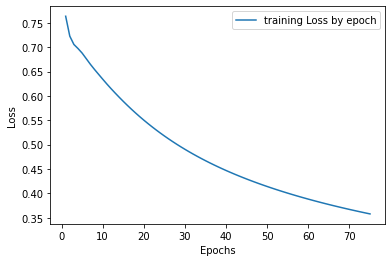

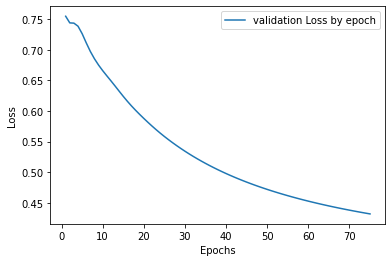

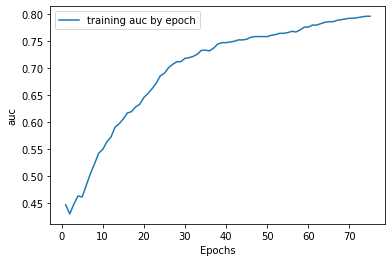

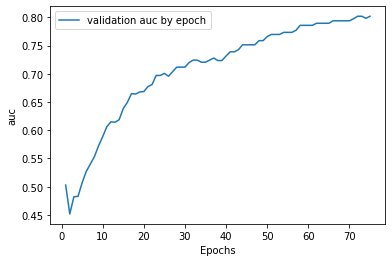

In [78]:
plot_loss_graph(tr_loss,val_loss)
plot_auc_graph(tr_auc,val_auc) 



**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [ ]:
net.features.fc=net.classifyer
net.features

# Comparing  ResNet18 with ResNet34:

#### Download the ResNet34 Network from torchvision.models. Then, repeat the steps described above in order to compare between these ResNet18 and ResNet34. Explain your findings and results!

In [79]:
net34 = MyResNet(34)
X_extracted_features_train = torch.empty([0, 512])
y_extracted_features_train = torch.empty([0]).long()
X_extracted_features_test = torch.empty([0, 512])
y_extracted_features_test = torch.empty([0]).long()

for X, y in tr_dataloader:

    extracted_batch_features = net34.extract_features(X)
    X_extracted_features_train = torch.cat(
        [X_extracted_features_train, extracted_batch_features], dim=0)
    y_extracted_features_train = torch.cat(
        [y_extracted_features_train, y], dim=0)

for X, y in val_dataloader:
    extracted_batch_features = net34.extract_features(X)
    X_extracted_features_test = torch.cat(
        [X_extracted_features_test, extracted_batch_features], dim=0)
    y_extracted_features_test = torch.cat(
        [y_extracted_features_test, y], dim=0)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Logistic Regression with scikit-learn library:

In [80]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000)
clf = logisticRegr.fit(X_extracted_features_train, y_extracted_features_train)
pred=clf.predict(X_extracted_features_test)
accurecy=clf.score(X_extracted_features_test,y_extracted_features_test)
auc=roc_auc_score(pred,y_extracted_features_test)

print('accurecy:',accurecy)
print('auc',auc)



accurecy: 0.812
auc 0.8109103722211545


# Logistic Regression with pytorch for ResNet34:

#### Define the model:

In [81]:
#Define above in MyResNet class
net34


MyResNet(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

#### Training and validation:

In [82]:
tr_loss, val_loss, test_loss, untrained_test_loss,auc_tr,val_auc = training_loop(
    args,
    net34,
    X_extracted_features_train,
    y_extracted_features_train,
    X_extracted_features_test,
    y_extracted_features_test,
    criterion_func=nn.CrossEntropyLoss
)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 8.04e-01, Val loss: 8.14e-01
Train loss: 7.57e-01, Val loss: 8.01e-01
Train loss: 7.38e-01, Val loss: 7.98e-01
Train loss: 7.27e-01, Val loss: 7.89e-01
Train loss: 7.13e-01, Val loss: 7.72e-01
Train loss: 6.98e-01, Val loss: 7.53e-01
Train loss: 6.84e-01, Val loss: 7.36e-01
Train loss: 6.70e-01, Val loss: 7.21e-01
Train loss: 6.58e-01, Val loss: 7.08e-01


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.45e-01, Val loss: 6.96e-01
Train loss: 6.32e-01, Val loss: 6.85e-01
Train loss: 6.20e-01, Val loss: 6.74e-01
Train loss: 6.09e-01, Val loss: 6.63e-01
Train loss: 5.98e-01, Val loss: 6.51e-01
Train loss: 5.87e-01, Val loss: 6.40e-01
Train loss: 5.77e-01, Val loss: 6.30e-01
Train loss: 5.67e-01, Val loss: 6.20e-01
Train loss: 5.57e-01, Val loss: 6.11e-01


100%|██████████| 5/5 [00:00<00:00, 338.32it/s]


Train loss: 5.48e-01, Val loss: 6.02e-01
Train loss: 5.39e-01, Val loss: 5.94e-01
Train loss: 5.30e-01, Val loss: 5.85e-01
Train loss: 5.22e-01, Val loss: 5.77e-01
Train loss: 5.14e-01, Val loss: 5.70e-01
Train loss: 5.07e-01, Val loss: 5.62e-01
Train loss: 4.99e-01, Val loss: 5.55e-01
Train loss: 4.92e-01, Val loss: 5.49e-01
Train loss: 4.85e-01, Val loss: 5.42e-01


100%|██████████| 5/5 [00:00<00:00, 278.73it/s]

Train loss: 4.79e-01, Val loss: 5.36e-01
Train loss: 4.73e-01, Val loss: 5.30e-01
Train loss: 4.66e-01, Val loss: 5.24e-01
Train loss: 4.61e-01, Val loss: 5.19e-01
Train loss: 4.55e-01, Val loss: 5.13e-01
Train loss: 4.49e-01, Val loss: 5.08e-01
Train loss: 4.44e-01, Val loss: 5.03e-01
Train loss: 4.39e-01, Val loss: 4.99e-01



  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 4.34e-01, Val loss: 4.94e-01
Train loss: 4.29e-01, Val loss: 4.90e-01
Train loss: 4.24e-01, Val loss: 4.85e-01
Train loss: 4.20e-01, Val loss: 4.81e-01
Train loss: 4.16e-01, Val loss: 4.77e-01
Train loss: 4.11e-01, Val loss: 4.74e-01
Train loss: 4.07e-01, Val loss: 4.70e-01
Train loss: 4.03e-01, Val loss: 4.66e-01
Train loss: 3.99e-01, Val loss: 4.63e-01


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.95e-01, Val loss: 4.59e-01
Train loss: 3.92e-01, Val loss: 4.56e-01
Train loss: 3.88e-01, Val loss: 4.53e-01
Train loss: 3.85e-01, Val loss: 4.50e-01
Train loss: 3.81e-01, Val loss: 4.47e-01
Train loss: 3.78e-01, Val loss: 4.44e-01
Train loss: 3.75e-01, Val loss: 4.41e-01
Train loss: 3.72e-01, Val loss: 4.39e-01


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.68e-01, Val loss: 4.36e-01
Train loss: 3.65e-01, Val loss: 4.34e-01
Train loss: 3.63e-01, Val loss: 4.31e-01
Train loss: 3.60e-01, Val loss: 4.29e-01
Train loss: 3.57e-01, Val loss: 4.27e-01
Train loss: 3.54e-01, Val loss: 4.24e-01
Train loss: 3.51e-01, Val loss: 4.22e-01
Train loss: 3.49e-01, Val loss: 4.20e-01
Train loss: 3.46e-01, Val loss: 4.18e-01


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.44e-01, Val loss: 4.16e-01
Train loss: 3.41e-01, Val loss: 4.14e-01
Train loss: 3.39e-01, Val loss: 4.12e-01
Train loss: 3.37e-01, Val loss: 4.10e-01
Train loss: 3.34e-01, Val loss: 4.08e-01
Train loss: 3.32e-01, Val loss: 4.07e-01
Train loss: 3.30e-01, Val loss: 4.05e-01
Train loss: 3.28e-01, Val loss: 4.03e-01
Train loss: 3.26e-01, Val loss: 4.02e-01


100%|██████████| 5/5 [00:00<00:00, 298.97it/s]

Train loss: 3.24e-01, Val loss: 4.00e-01
Train loss: 3.21e-01, Val loss: 3.99e-01
Train loss: 3.19e-01, Val loss: 3.97e-01
Train loss: 3.18e-01, Val loss: 3.96e-01
Train loss: 3.16e-01, Val loss: 3.94e-01
Stopped training after 75/75 epochs.
The loss is 8.59e-01 before training and 3.94e-01 after training.
The training and validation losses are 
	[0.8041818237304688, 0.7572620391845704, 0.7376683044433594, 0.7265982055664062, 0.713467025756836, 0.6982980346679688, 0.6837265014648437, 0.6703936004638672, 0.6575114440917968, 0.644708251953125, 0.6322480010986328, 0.6203112030029296, 0.6088124084472656, 0.5976732635498047, 0.5869140625, 0.576556396484375, 0.5665869903564453, 0.5569913864135743, 0.5477629852294922, 0.5388895416259766, 0.5303532791137695, 0.5221387481689453, 0.514232406616211, 0.5066223526000977, 0.4992950439453125, 0.49223789215087893, 0.48543807983398435, 0.478883056640625, 0.4725607299804688, 0.4664599609375, 0.4605699157714844, 0.45488079071044923, 0.44938289642333984, 

#### Visualizing the plots:

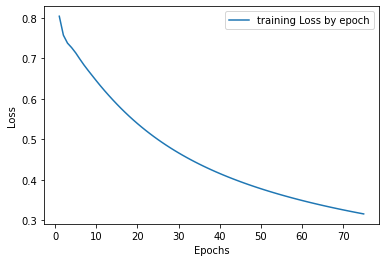

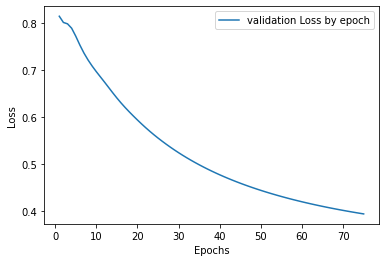

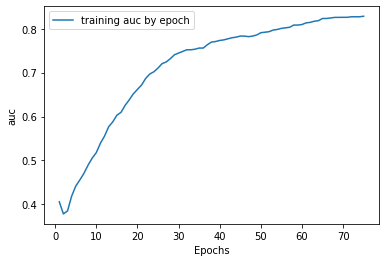

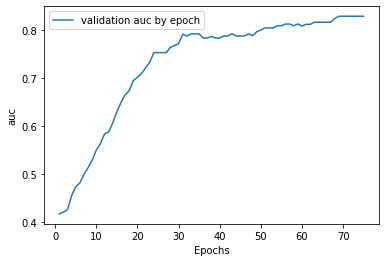

In [84]:
plot_loss_graph(tr_loss, "training")
plot_loss_graph(val_loss, "validation")
plot_auc_graph(auc_tr, "training")
plot_auc_graph(val_auc, "validation") 



**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [ ]:
### START CODE HERE ###


# Part 2- Fine-tuning

In the feature extraction experiment above you were training the classifier on the top of the pre-trained model. 
In this paert, you need to train (or "fine-tune") the original pre-trained Resnet18 model (or part of them) in an attempts to improve your results. You can determine the number of convolution layers you intend to re-train in order to avoid overfitting and hopefully achive better generalization. Note that the fine-tuning should only be attempted after you have trained the top-level classifier with a pre-trained model.

1. Plot Loss and Accuracy v.s Epoch for train and validation sets:

#### Define the model (use the merged feature extractor with the PyTorch logistic regression classifier)

In [90]:
net_param=net.features
for param in net_param.parameters():
  param.requires_grad = True


#### Training and validation:

In [91]:
tr_loss, val_loss, test_loss, untrained_test_loss,auc_tr,val_auc = training_loop(
    args,
    net,
    X_extracted_features_train,
    y_extracted_features_train,
    X_extracted_features_test,
    y_extracted_features_test,
    criterion_func=nn.CrossEntropyLoss
)

100%|██████████| 5/5 [00:00<00:00, 303.23it/s]


Train loss: 2.89e-01, Val loss: 3.80e-01
Train loss: 2.86e-01, Val loss: 3.80e-01
Train loss: 2.84e-01, Val loss: 3.78e-01
Train loss: 2.81e-01, Val loss: 3.76e-01
Train loss: 2.79e-01, Val loss: 3.74e-01
Train loss: 2.77e-01, Val loss: 3.73e-01
Train loss: 2.75e-01, Val loss: 3.72e-01
Train loss: 2.72e-01, Val loss: 3.70e-01
Train loss: 2.70e-01, Val loss: 3.69e-01
Train loss: 2.68e-01, Val loss: 3.68e-01


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.66e-01, Val loss: 3.66e-01
Train loss: 2.64e-01, Val loss: 3.65e-01
Train loss: 2.63e-01, Val loss: 3.64e-01
Train loss: 2.61e-01, Val loss: 3.63e-01
Train loss: 2.59e-01, Val loss: 3.62e-01
Train loss: 2.57e-01, Val loss: 3.61e-01
Train loss: 2.56e-01, Val loss: 3.60e-01
Train loss: 2.54e-01, Val loss: 3.60e-01
Train loss: 2.52e-01, Val loss: 3.59e-01


100%|██████████| 5/5 [00:00<00:00, 330.00it/s]


Train loss: 2.51e-01, Val loss: 3.58e-01
Train loss: 2.49e-01, Val loss: 3.57e-01
Train loss: 2.48e-01, Val loss: 3.56e-01
Train loss: 2.46e-01, Val loss: 3.56e-01
Train loss: 2.45e-01, Val loss: 3.55e-01
Train loss: 2.43e-01, Val loss: 3.54e-01
Train loss: 2.42e-01, Val loss: 3.54e-01
Train loss: 2.40e-01, Val loss: 3.53e-01
Train loss: 2.39e-01, Val loss: 3.53e-01
Train loss: 2.38e-01, Val loss: 3.52e-01


100%|██████████| 5/5 [00:00<00:00, 339.70it/s]


Train loss: 2.37e-01, Val loss: 3.52e-01
Train loss: 2.35e-01, Val loss: 3.51e-01
Train loss: 2.34e-01, Val loss: 3.51e-01
Train loss: 2.33e-01, Val loss: 3.50e-01
Train loss: 2.32e-01, Val loss: 3.50e-01
Train loss: 2.30e-01, Val loss: 3.49e-01
Train loss: 2.29e-01, Val loss: 3.49e-01
Train loss: 2.28e-01, Val loss: 3.48e-01
Train loss: 2.27e-01, Val loss: 3.48e-01


100%|██████████| 5/5 [00:00<00:00, 337.22it/s]

Train loss: 2.26e-01, Val loss: 3.48e-01
Train loss: 2.25e-01, Val loss: 3.47e-01
Train loss: 2.24e-01, Val loss: 3.47e-01
Train loss: 2.23e-01, Val loss: 3.47e-01
Train loss: 2.21e-01, Val loss: 3.46e-01
Train loss: 2.20e-01, Val loss: 3.46e-01
Train loss: 2.19e-01, Val loss: 3.46e-01
Train loss: 2.18e-01, Val loss: 3.46e-01



  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.17e-01, Val loss: 3.45e-01
Train loss: 2.16e-01, Val loss: 3.45e-01
Train loss: 2.15e-01, Val loss: 3.45e-01
Train loss: 2.15e-01, Val loss: 3.45e-01
Train loss: 2.14e-01, Val loss: 3.44e-01
Train loss: 2.13e-01, Val loss: 3.44e-01
Train loss: 2.12e-01, Val loss: 3.44e-01
Train loss: 2.11e-01, Val loss: 3.44e-01
Train loss: 2.10e-01, Val loss: 3.44e-01


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.09e-01, Val loss: 3.43e-01
Train loss: 2.08e-01, Val loss: 3.43e-01
Train loss: 2.07e-01, Val loss: 3.43e-01
Train loss: 2.06e-01, Val loss: 3.43e-01
Train loss: 2.06e-01, Val loss: 3.43e-01
Train loss: 2.05e-01, Val loss: 3.43e-01
Train loss: 2.04e-01, Val loss: 3.42e-01
Train loss: 2.03e-01, Val loss: 3.42e-01
Train loss: 2.02e-01, Val loss: 3.42e-01


100%|██████████| 5/5 [00:00<00:00, 350.23it/s]

Train loss: 2.02e-01, Val loss: 3.42e-01
Train loss: 2.01e-01, Val loss: 3.42e-01
Train loss: 2.00e-01, Val loss: 3.42e-01
Train loss: 1.99e-01, Val loss: 3.42e-01
Train loss: 1.98e-01, Val loss: 3.42e-01
Train loss: 1.98e-01, Val loss: 3.42e-01
Train loss: 1.97e-01, Val loss: 3.41e-01
Train loss: 1.96e-01, Val loss: 3.41e-01
Stopped training after 72/75 epochs.
The loss is 3.82e-01 before training and 3.41e-01 after training.
The training and validation losses are 
	[0.28905513763427737, 0.28614412307739256, 0.28370401382446286, 0.28130313873291013, 0.27896595001220703, 0.2766966247558594, 0.2745020294189453, 0.2723714828491211, 0.27029478073120117, 0.26827213287353513, 0.26630411148071287, 0.2643897247314453, 0.2625249290466309, 0.2607059669494629, 0.25893075942993166, 0.25719829559326174, 0.255506706237793, 0.2538539123535156, 0.25223785400390625, 0.25065696716308594, 0.24910985946655273, 0.24759536743164062, 0.24611186981201172, 0.24465824127197267, 0.2432331085205078, 0.2418355560

#### Visualizing the plots:

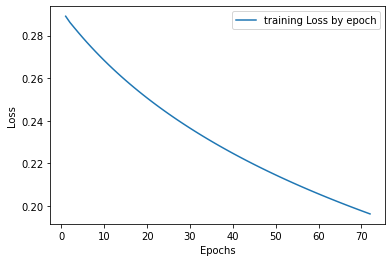

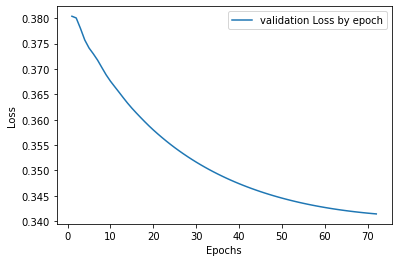

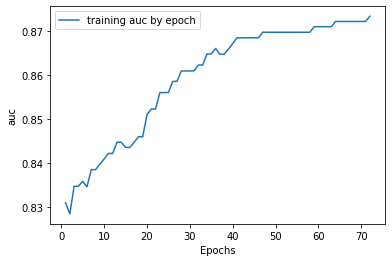

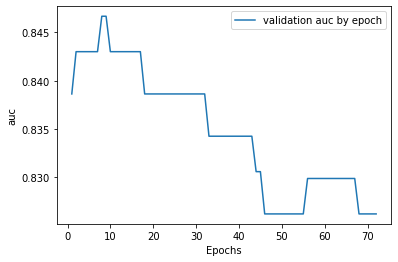

In [92]:
plot_loss_graph(tr_loss, "training")
plot_loss_graph(val_loss, "validation")
plot_auc_graph(auc_tr, "training")
plot_auc_graph(val_auc, "validation") 



2. Compare your results between the two approaches. Is there any improvement? Explain your findings...


Type your answer here:
